In [131]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as display
import PIL.Image
from tensorflow.keras.preprocessing import image
import os

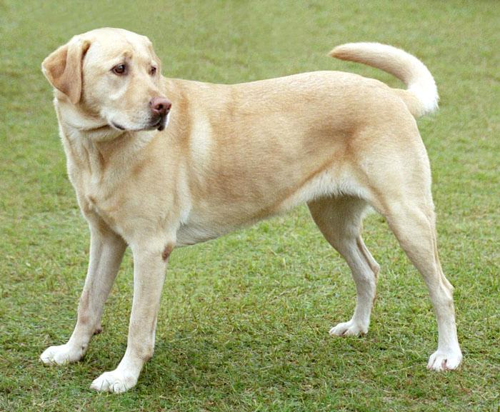

In [103]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

# Downsizing the image makes it easier to work with.
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('PJESEK ŚLICZNY *.* UwU'))

In [45]:
original_img = PIL.Image.open('bogini.jpg')
# original_img = deprocess(np.array(original_img))

In [6]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 31s 0us/step


In [7]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [8]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [9]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [10]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [132]:
dream_model.save(os.path.join('models', 'dream_model.h5'))

In [11]:
deepdream = DeepDream(dream_model)

In [12]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

In [40]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

TypeError: unsupported operand type(s) for /=: 'PngImageFile' and 'float'

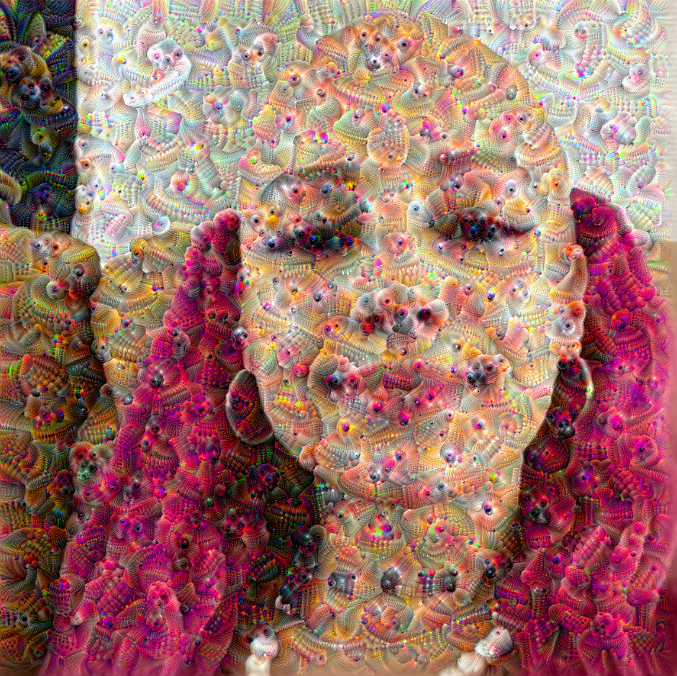

328.79741740226746

In [46]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img_reshaped = tf.image.resize(img, base_shape)
img_reshaped = tf.image.convert_image_dtype(img_reshaped/255.0, dtype=tf.uint8)
show(img_reshaped)

end = time.time()
end-start

In [38]:
PIL.Image.fromarray(np.array(img)).save('aaaa.jpg', "JPEG")

In [47]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [48]:
get_tiled_gradients = TiledGradients(dream_model)

In [63]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  
    lr = tf.constant(0.02)
    beta1 = tf.constant(0.9)
    beta2 = tf.constant(0.999)
    epsilon = tf.constant(1e-8)
    t = 1
    m = 0
    v = 0

    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))
        t = 1
        m = 0
        v = 0

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)

            m = beta1*m + (1 - beta1)*gradients
            v = beta2*v + (1 - beta2) * (gradients**2)

            m_reg = m / (1 - beta1**t)
            v_reg = v / (1 - beta2**t)
            new_grads = (lr * m_reg) / (tf.sqrt(v_reg + epsilon))

            t += 1

            img = img + new_grads
            img = tf.clip_by_value(img, -1, 1)

            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(img))
                print ("Octave {}, Step {}".format(octave, step))

    result = deprocess(img)
    return result

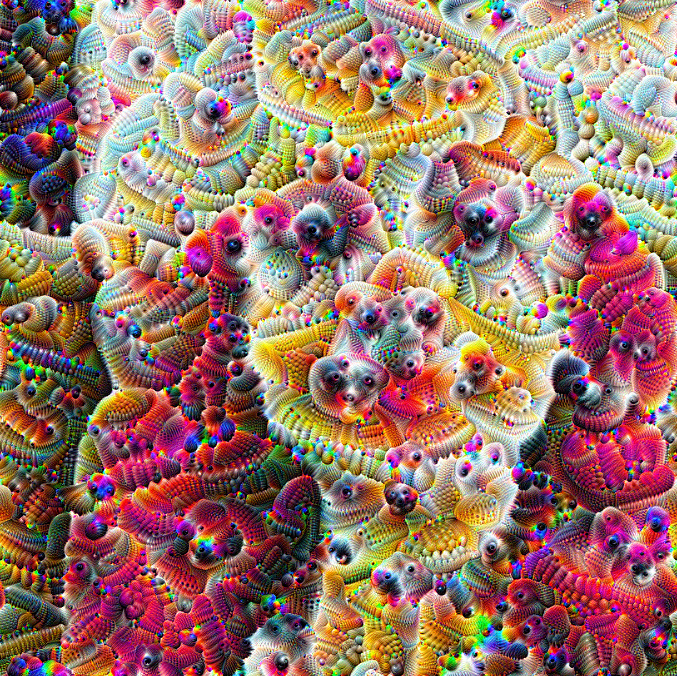

In [69]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01, octave_scale=1.8, octaves=range(-3, 2))

display.clear_output(wait=True)
img_reshaped = tf.image.resize(img, base_shape)
img_reshaped = tf.image.convert_image_dtype(img_reshaped/255.0, dtype=tf.uint8)
show(img_reshaped)

In [76]:
PIL.Image.fromarray(img.numpy()).save('piekna.jpg', 'JPEG')

In [77]:
import pickle

In [80]:
pickle.dump(run_deep_dream_with_octaves, open('test.pkl', 'wb'))

In [121]:
class Deepdream_Model:
    
    def __init__(self, deepdream, dream_model, loss_function, grad_class, deprocess_function):
        
        self.get_tiled_gradients = grad_class
        self.calc_loss = loss_function
        self.deepdream = deepdream
        self.dream_model = dream_model
        self.deprocess = deprocess_function
        
    def __call__(self, img, steps_per_octave=100, step_size=0.02, 
                                octaves=range(-2,3), octave_scale=1.3):
    
        # Adam optimizer params
        lr = tf.constant(step_size)
        beta1 = tf.constant(0.9)
        beta2 = tf.constant(0.999)
        epsilon = tf.constant(1e-8)

        base_shape = tf.shape(img)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.keras.applications.inception_v3.preprocess_input(img)

        initial_shape = img.shape[:-1]
        img = tf.image.resize(img, initial_shape)
        for octave in octaves:
            # Scale the image based on the octave
            new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
            img = tf.image.resize(img, tf.cast(new_size, tf.int32))
            t = 1
            m = 0
            v = 0

            for step in range(steps_per_octave):
                gradients = self.get_tiled_gradients(img)

                m = beta1*m + (1 - beta1)*gradients
                v = beta2*v + (1 - beta2) * (gradients**2)

                m_reg = m / (1 - beta1**t)
                v_reg = v / (1 - beta2**t)
                new_grads = (lr * m_reg) / (tf.sqrt(v_reg + epsilon))

                t += 1

                img = img + new_grads
                img = tf.clip_by_value(img, -1, 1)

        result = self.deprocess(img)
        result = tf.image.convert_image_dtype(result, dtype=tf.uint8).numpy()
        result = PIL.Image.fromarray(result)
        return result
    

In [124]:
for i in [deepdream, dream_model, calc_loss, get_tiled_gradients, deprocess]:
    print(i)
    pickle.dump(i, open(str(i), 'wb'))

OSError: [Errno 22] Invalid argument: '<__main__.DeepDream object at 0x0000020056EA1A30>'

In [129]:
deepdream.save('aaa.h5')

AttributeError: 'DeepDream' object has no attribute 'save'

In [122]:
mine_model = Deepdream_Model(deepdream, dream_model, calc_loss, get_tiled_gradients, deprocess)

In [114]:
dream_model.compile('ADAM', None)

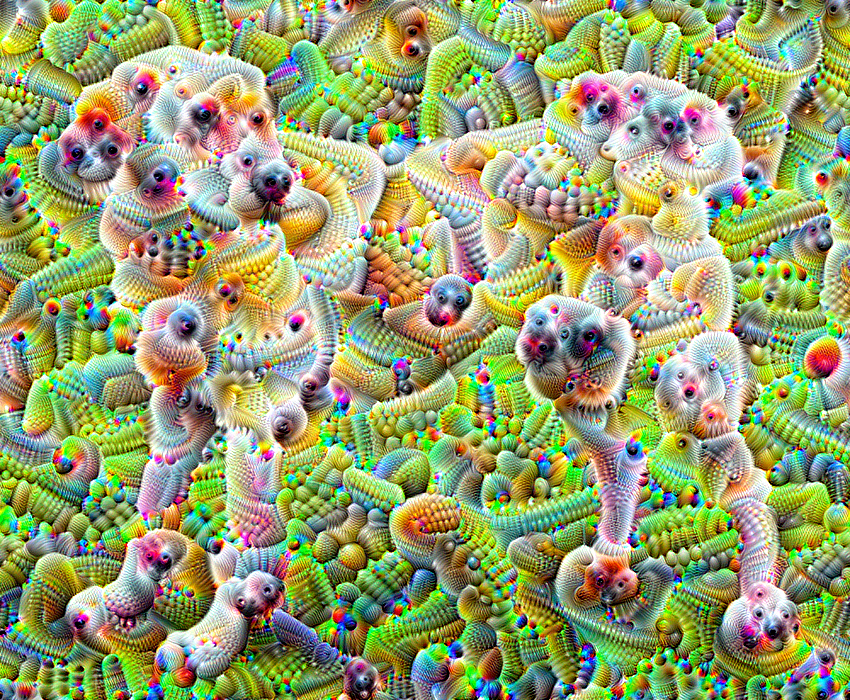

In [105]:
result = mine_model(original_img, octaves=range(-2, 2), octave_scale=1.7)
result

In [107]:
result.save('PJESEK_SLICZNY.jpg', 'JPEG')

In [123]:
pickle.dump(mine_model, open('deepdream_model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://b9ea9797-015c-42a2-8f08-5ddc944c2a5d/assets


NotFoundError: 

In [118]:
import sys
sys.getsizeof(mine_model)

48

In [120]:
mine_model